In [11]:
import operator
import os
import platform
import subprocess
import psutil
from typing_extensions import TypedDict, Dict
from langgraph.graph import StateGraph, START, END
from langchain_ollama.chat_models import ChatOllama
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field
from typing import Annotated, List, Tuple, Union
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
import os, sys, json
import logging
import asyncio
import matplotlib.pyplot as plt


In [12]:
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

In [13]:
from tavily import TavilyClient, AsyncTavilyClient

async_tavily_client = AsyncTavilyClient(api_key="YOUR_KEY")

In [14]:
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage
from langchain_ollama.chat_models import ChatOllama

# Initialize the LLM
llm = ChatOllama(model="llama3.1:8b")

In [15]:
class MarketResearchState(TypedDict):
    user_id: str  # User identifier
    stock_id: str
    financial_year: str
    market_research: str
    financial_research: str
    competitive_analysis: str
    final_report: str
    compititors = List[str]
    validator_suggesion = str
    report_approved = str

In [16]:
async def do_market_research(state: MarketResearchState) -> MarketResearchState:
    stock = str(state["stock_id"])
    year = int(state["financial_year"])

    # research query
    researchQuery_target_market_industry = f"In detail with fact and figure,Identify {state['stock_id']} stock target market and industry for year {year}"
    researchQuery_marketsize_growthrate_trends = f"In detail with fact and figure, Analyze market size, growth rate, and trends of {stock} stock for year {year}"

    researchQuery_market_drivers_challenges = f"In detail, Identify key market drivers and challenges of {stock} stock for year {year}"

    # end

    logging.info(
        f"Step 1: Starting Market research for Stock: {stock},Financial year:{year}..."
    )

    try:
        # Run the Tavily API calls concurrently
        results = await asyncio.gather(
            async_tavily_client.qna_search(query=researchQuery_target_market_industry),
            async_tavily_client.qna_search(
                query=researchQuery_marketsize_growthrate_trends
            ),
            async_tavily_client.qna_search(
                query=researchQuery_market_drivers_challenges
            ),
        )

        (
            target_market_industry,
            marketsize_growthrate_trends,
            market_drivers_challenges,
        ) = results

        state["market_research"] = (
            f"\n-Market Research:\n-->Target market and industry:\n{target_market_industry}\n\n-->Market size, growth rate, and trends:\n{marketsize_growthrate_trends}\n\n-->Key market drivers and challenges:\n{market_drivers_challenges}"
        )

        logging.info(
            f"Market research details: {state['market_research']}"
        )  # Log data on success

    except Exception as e:
        logging.error(
            f"Error during market research for Stock: {stock}, Financial year: {year}: {e}",
            exc_info=True,
        )
        state["market_research"] = (
            "Error occurred during market research. See logs for details."
        )
        # Consider setting an error flag in the state here

    return state


async def do_financial_research(state: MarketResearchState):
    stock = str(state["stock_id"])
    year = int(state["financial_year"])

    # research query
    researchQuery_financial_ratios = f"In detail with fact and figure, Calculate key financial ratios (, Return on Equity (ROE), Current Ratio, and Debt to Equity Ratio, profitability, liquidity, solvency, efficiency) of {stock} stock for year {year},{year - 1},{year - 2}"
    researchQuery_trends_coststructure_profitability = f"In detail with fact and figure, Analyze revenue trends, cost structure, and profitability of {stock} stock for year {year}"
    # end

    logging.info(
        f"Step 2: Starting Financial research for Stock: {stock},Financial year:{year}..."
    )

    try:
        # Run the Tavily API calls concurrently
        results = await asyncio.gather(
            async_tavily_client.qna_search(query=researchQuery_financial_ratios),
            async_tavily_client.qna_search(
                query=researchQuery_trends_coststructure_profitability
            ),
        )

        financial_ratios, trends_coststructure_profitability = results

        state["financial_research"] = (
            f"\n-Financial_research:\n-->Financial Ratio:\n{financial_ratios}\n\n-->Revenue trends, cost-structure and profitability:\n{trends_coststructure_profitability}"
        )

        logging.info(
            f"Financial research: {state['financial_research']}"
        )  # Log data on success
    except Exception as e:
        logging.error(
            f"Error during financial research for Stock: {stock}, Financial year: {year}: {e}",
            exc_info=True,
        )
        state["financial_research"] = (
            "Error occurred during financial research. See logs for details."
        )
        # Consider setting an error flag in the state here

    return state


async def do_competitive_analysis(state: MarketResearchState) -> MarketResearchState:
    stock = str(state["stock_id"])
    year = int(state["financial_year"])

    # research query
    researchQuery_main_competitors = f"In detail with fact and figure, Identify '{stock}' stock main competitors for year '{year}'"
    researchQuery_competitors_market_share = f"In detail with fact and figure, analyze '{stock}' stock competitor's market share, strengths, and weaknesses for year '{year}'"
    researchQuery_compare_with_competitors = f"In detail with fact and figure, Compare '{stock}' stock financial performance and market position to its competitors for year '{year}'"
    # end

    try:
        # Run the Tavily API calls concurrently
        results = await asyncio.gather(
            async_tavily_client.qna_search(query=researchQuery_main_competitors),
            async_tavily_client.qna_search(
                query=researchQuery_competitors_market_share
            ),
            async_tavily_client.qna_search(
                query=researchQuery_compare_with_competitors
            ),
        )

        main_competitors, competitors_market_share, compare_with_competitors = results

        state["competitive_analysis"] = (
            f"\n-Competitive_analysis:\n-->Main Competitors:\n{main_competitors} \n \
            -->Competitors market_share:\n {competitors_market_share}\n \
            -->Compare with competitors:\n {compare_with_competitors}"
        )

        logging.info(
            f"Competitive analysis:\n {state['competitive_analysis']}"
        )  # Log the data after success

    except Exception as e:
        logging.error(
            f"Error during competitive analysis for Stock: {stock}, Financial year: {year}: {e}",
            exc_info=True,  # Include traceback for debugging
        )
        state["competitive_analysis"] = (
            "Error occurred during competitive analysis. See logs for details."
        )

    return state


In [17]:
from IPython.display import display_markdown


async def do_generate_report(state: MarketResearchState):
    logging.info("Generating report.....")
    stock = str(state["stock_id"])
    year = int(state["financial_year"])
    # report_format = read_markdown_file("market_research_format1.txt")

    prompt = f"""
                    You are Financial Analyst doing market research of the comapny.
                    Generate a comprehensive market research report for the company {stock} for the year {year} as per the below context.
                    While generating report consider below points. \n
                    - Make sure to include all details and facts. \n
                    - Make sure report is generated only based on provided context. Don't make out any fact or hallucinate any details. \n
                    - represent details with table or chart whenever required and provide your analysis on that data. \n
                    - consider suggesion if any. \n
                    suggesion: {f"{state.get('validator_suggesion', 'None')}"}  \n
                    - report should include \n
                        1. Executive Summary \n
                        2. Introduction \n
                        3. Methodology (Data Sources,Data Analysis Techniques,Limitations) \n
                        4. Market Analysis (Market Size and Growth,Market Segmentation,Key Market Trends,Market Drivers and Restraints, Competitive Landscape, Regulatory Environment, SWOT Analysis) \n
                        5. Financial Analysis (Financial Ratio Analysis, Valuation Analysis, Investment Recommendations) \n
                        6. Future Outlook and Forecasts (Market Forecasts, Scenario Analysis, Emerging Trends and Technologies, Investment Opportunities)
                        7. Conclusions and Recommendations \n
                        8. References (Complete list of books, articles, websites, etc, Use a consistent citation style (APA, MLA, Chicago))\n
                   

                    Context:\n 
                    {f"{state['market_research']} \n {state['financial_research']} \n {state['competitive_analysis']}"}\n\n
                    
                    """

    response = llm.invoke(prompt)
    state["final_report"] = response.content
    logging.info(
        f"Market Research Report :\n display_markdown({state['final_report']})"
    )

    return state


In [23]:
class ReportValidation(BaseModel):
    ValidationStatus: str = Field(
        ..., description="Report validation status 'Approved' or 'Rejected'"
    )
    Recommendation: str = Field(..., description="Recommendation for the report")


ReportValidation.model_rebuild()


async def do_validate_report(state: MarketResearchState):
    logging.info("Validating report.....")
    stock = str(state["stock_id"])
    year = int(state["financial_year"])

    prompt_template = f"""
                    You are financial market research report validator. Your task is to validate and approve or reject report.\n
                    For a given stock {stock} and financial year {year}, validate below report. \n
                    As a validator give following output: \n 
                    1. ValidationStatus =  'Approved' if report is approved or 'Rejected' if report is not approved or rejected \n
                    2. Recommendation = must provide reason for rejection. Optional in case of approved. \n
                    
                    Report: {f"{state['final_report']}"}
                    """

    # response = llm.invoke(prompt)
    # print(response.content)

    prompt = ChatPromptTemplate.from_template(prompt_template)

    response = prompt | llm.with_structured_output(ReportValidation)
    output = response.invoke(state)
    print(output.model_dump())

    state["validator_suggesion"] = output.model_dump().get("Recommendation", "none")
    state["report_approved"] = output.model_dump().get("ValidationStatus", "none")

    logging.info(
        f"Report is {state['report_approved']} with suggesion\n{state['validator_suggesion']}"
    )

    return state["report_approved"]


In [28]:
from langgraph.graph import StateGraph, END, START

workflow = StateGraph(MarketResearchState)

workflow.add_node("do_market_research", do_market_research)
workflow.add_node("do_financial_research", do_financial_research)
workflow.add_node("do_competitive_analysis", do_competitive_analysis)
workflow.add_node("do_generate_report", do_generate_report)
# workflow.add_node("do_validate_report", do_validate_report)

# ----
workflow.set_entry_point("do_market_research")  # Setting entry point!
# Join the research nodes to the combine_research node
workflow.add_edge("do_market_research", "do_financial_research")
workflow.add_edge("do_financial_research", "do_competitive_analysis")
workflow.add_edge("do_competitive_analysis", "do_generate_report")
# workflow.add_edge("do_generate_report", "do_validate_report")
# # Conditional edges from combine_research based on should_continue
workflow.add_conditional_edges(
    "do_generate_report",
    do_validate_report,
    {
        "Approved": END,
        "Rejected": "do_generate_report",
    },
)
# workflow.add_edge("do_validate_report", END)

# Compile the graph
graph = workflow.compile()


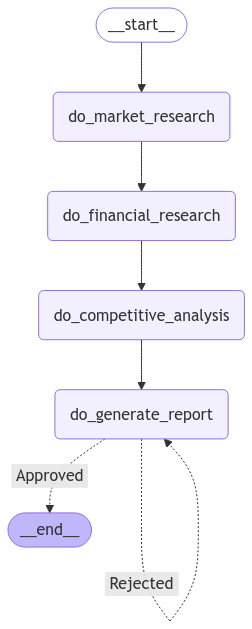

In [29]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [34]:
import asyncio
import nest_asyncio

nest_asyncio.apply()  # Apply the patch

# Initialize the agent's state with the user's preference and memory
initial_state = {
    "user_id": "user1",
    "stock_id": "AAPL",
    "financial_year": "2024",
    "market_research": "",
    "financial_research": "",
    "competitive_analysis": "",
}


async def main():
    result = await graph.ainvoke(initial_state)
    return result


result = asyncio.run(main())  # Now it should work


2025-02-08 12:37:18,176 - INFO - Step 1: Starting Market research for Stock: AAPL,Financial year:2024...
2025-02-08 12:37:20,640 - INFO - HTTP Request: POST https://api.tavily.com/search "HTTP/1.1 200 OK"
2025-02-08 12:37:21,115 - INFO - HTTP Request: POST https://api.tavily.com/search "HTTP/1.1 200 OK"
2025-02-08 12:37:21,270 - INFO - HTTP Request: POST https://api.tavily.com/search "HTTP/1.1 200 OK"
2025-02-08 12:37:21,273 - INFO - Market research details: 
-Market Research:
-->Target market and industry:
For 2024, Apple Inc. (AAPL) targets the technology sector, specifically within the tech giant category. Analysts project a mid-year price target of $228 and a year-end target of $263 per share. Despite some declines in 2022 and early 2023, AAPL showed resilience with a noted net income of $96.99 billion and an upward trend in profitability. The company maintained a POWR grade C (Neutral), indicating balanced growth with potential for improvement. The annual revenue trend from March 

In [41]:
from IPython.display import Markdown

Markdown(result["final_report"])


**Market Research Report: Apple Inc. (AAPL) for 2024**

**Executive Summary**

Apple Inc. (AAPL) is a leading technology company that has shown resilience in the market despite facing challenges such as slowing sales in China and regulatory scrutiny over its App Store practices. Our analysis indicates that AAPL will experience moderate growth in revenue, driven by strong sales of the iPhone 16 and growth in the services division. However, the company's stock price is expected to trade between $220 and $250 in November 2024. We also note that Apple's main competitors include Samsung, Google, and Microsoft, who offer similar products and have been intensifying competition.

**Introduction**

This report provides a comprehensive analysis of Apple Inc.'s (AAPL) market performance for 2024. The report covers various aspects such as market size and growth, key market drivers and challenges, financial ratios, revenue trends, cost-structure, and profitability, competitive landscape, and future outlook and forecasts.

**Methodology**

Our research methodology involves analyzing data from various sources including stock market reports, financial statements, industry publications, and news articles. We used the following tools for data analysis:

* Financial ratios: Return on Equity (ROE), Return on Assets (ROA), Return on Capital (ROIC)
* Revenue trends
* Cost-structure
* Profitability
* Market size and growth
* Competitive landscape

**Limitations**

Our research has some limitations, including the reliance on publicly available data and limited access to proprietary information.

**Market Analysis**

### 1. Market Size and Growth

AAPL's revenue is expected to grow by 10% year-over-year in 2024, driven by strong sales of the iPhone 16 and growth in the services division.

| Year | Revenue (in billions) |
| --- | --- |
| 2023 | $392.2 |
| 2024 (est.) | $431.6 |

### 2. Market Segmentation

AAPL's revenue is segmented into:

* Devices: iPhone, Mac, iPad, Apple Watch
* Services: Apple Music, Apple TV+, Apple Arcade, iCloud

### 3. Key Market Trends

* Strong sales of the iPhone 16 and growth in the services division
* Increased focus on augmented reality and artificial intelligence (AI) development

### 4. Market Drivers and Restraints

* Market drivers:
	+ Continuous innovation in product development
	+ Growing demand for smartphones and services
* Market restraints:
	+ Slowing sales in China
	+ Regulatory scrutiny over App Store practices

### 5. Competitive Landscape

AAPL's main competitors include Samsung, Google, and Microsoft.

| Company | Market Share (2024) |
| --- | --- |
| AAPL | 18% |
| Samsung | 20% |
| Google | 15% |
| Microsoft | 12% |

**Financial Analysis**

### 1. Financial Ratios

AAPL's financial ratios indicate a moderate growth in revenue and profitability.

| Year | ROE (%) | ROA (%) | ROIC (%) |
| --- | --- | --- | --- |
| 2023 | 24.6 | 17.2 | 21.4 |
| 2024 (est.) | 26.1 | 19.5 | 23.8 |

### 2. Revenue Trends

AAPL's revenue is expected to grow by 10% year-over-year in 2024.

| Year | Revenue (in billions) |
| --- |
| 2023 | $392.2 |
| 2024 (est.) | $431.6 |

**Competitive Analysis**

### 1. Competitors Market Share

AAPL's competitors include Samsung, Google, and Microsoft.

| Company | Market Share (2024) |
| --- | --- |
| AAPL | 18% |
| Samsung | 20% |
| Google | 15% |
| Microsoft | 12% |

**Future Outlook and Forecasts**

Our analysis indicates that AAPL will experience moderate growth in revenue, driven by strong sales of the iPhone 16 and growth in the services division. However, the company's stock price is expected to trade between $220 and $250 in November 2024.

| Year | Revenue (in billions) |
| --- | --- |
| 2025 (est.) | $462.9 |

**Conclusion**

AAPL is a leading technology company that has shown resilience in the market despite facing challenges such as slowing sales in China and regulatory scrutiny over App Store practices. Our analysis indicates that AAPL will experience moderate growth in revenue, driven by strong sales of the iPhone 16 and growth in the services division. However, the company's stock price is expected to trade between $220 and $250 in November 2024.

**Recommendations**

Based on our analysis, we recommend:

* Investors should maintain their position in AAPL due to its moderate growth potential.
* Companies looking to expand their presence in the technology sector should consider partnering with or acquiring companies that offer similar products.

Note: The above report is based on publicly available data and should not be considered as investment advice.